In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Input, Embedding, Concatenate, Conv1D, Add, Multiply, LSTM, Lambda, Flatten
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.preprocessing import sequence, text
from tensorflow.keras.losses import SparseCategoricalCrossentropy, CategoricalCrossentropy
from tensorflow.keras import callbacks
from tensorflow.keras.utils import plot_model
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import os
import glob
import json
import rdkit
from rdkit import Chem
from tqdm import tqdm
from tqdm import tqdm_notebook
import time
import datetime
import matplotlib.pyplot as plt

2024-06-06 10:09:31.837729: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-06 10:09:32.387848: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Hyperparameters

In [3]:
# Data loading parameters
DATASET_DIR = './datasets/'
SMILES_FILENAME = '250k_rndm_zinc_drugs_clean'
MAPPING_DIR = './mapping/'
MAPPING_TABLE_DIR = MAPPING_DIR + SMILES_FILENAME

# Model Hyperparameters
SMILES_MAX_LEN = 50
EMBEDDING_DIM = 128
FILTER_SIZES = (3, 4)
FILTER_NUM = 128
LATENT_DIM = 300
LSTM_CELLS_NUM = LATENT_DIM//2
DIVERSITY = 1

# Training Parameters 
BATCH_SIZE = 64
NUM_EPOCHS = 100
CHECKPOINT_PERIOD = 50
LR = 0.001

# Load mapping table
with open(MAPPING_TABLE_DIR + '/tokenizer.json', 'r') as f:
    tokenizer = text.tokenizer_from_json(json.load(f))

SMILES_DIM = len(tokenizer.word_index)

## Load Training Dataset

In [14]:
# Load training data
x_train = []
smiles_counter = 0
with open(DATASET_DIR + SMILES_FILENAME + '.smi') as f:
    for smiles in tqdm(f.readlines()):
        # Mapping
        if len(smiles) < SMILES_MAX_LEN:
            smiles_counter += 1
            sequences = tokenizer.texts_to_sequences([smiles])
            padded_sequences = sequence.pad_sequences(sequences, maxlen=SMILES_MAX_LEN, padding='post', value=tokenizer.word_index['<PAD>'])
            x_train.append(padded_sequences)
        
x_train = np.squeeze(np.array(x_train))

100%|██████████| 2/2 [00:00<00:00, 15887.52it/s]


In [15]:
print("Total training dataset: {}".format(x_train.__len__()))

Total training dataset: 2


In [16]:
# Save token
np.save(MAPPING_TABLE_DIR + '/token', x_train)

print(x_train[0])
print(x_train[0].shape)
print(x_train.shape)

[ 2  2  2  2  2  2 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36
 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36
 36 36]
(50,)
(2, 50)


In [17]:
# Shuffle data
np.random.shuffle(x_train)

print('x_train shape:', x_train.shape)

x_train shape: (2, 50)


## VAE Model (subclassing version)

### Encoder (subclassing layer API)

In [18]:
class Sampling(keras.layers.Layer):
    def __init__(self, lstm_cells_num, name='Sampling'):
        super(Sampling, self).__init__()
        self.lstm_cells_num = lstm_cells_num
        self.diversity = 1
        
    def call(self, x):
        z_mean, z_logvar = x
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        
        # latent variable
        normal_z = tf.random.normal(shape=(batch, dim), name='normal', stddev=(1.0 * self.diversity))
        z = z_mean + z_logvar * normal_z # original CDN code
        
        # decoder input
        state_h, state_c = z[:, :self.lstm_cells_num], z[:, self.lstm_cells_num:]
        
        # KL-divergence
        kl_loss = 0.5 * tf.reduce_sum(tf.square(z_mean) + tf.square(z_logvar) - tf.math.log(tf.square(z_logvar)) - 1, 1)
        kl_loss = tf.reduce_mean(kl_loss)
        
        return z, kl_loss, state_h, state_c
    
    def set_diversity(self, diversity):
        self.diversity = diversity
        
    def get_config(self):
        return {
            "diversity": self.diversity
        }

In [19]:
class Encoder(keras.layers.Layer):
    def __init__(self, smiles_dim, smiles_max_len, embedding_dim, filter_sz, filter_num, latent_dim, lstm_cells_num, name='Encoder'):
        super(Encoder, self).__init__()
        self.smiles_dim = smiles_dim
        self.smiles_max_len = smiles_max_len
        self.embedding_dim = embedding_dim
        self.filter_sz = filter_sz
        self.filter_num = filter_num
        self.latent_dim = latent_dim
        self.lstm_cells_num = lstm_cells_num
        
        self.embedding = Embedding(input_dim=self.smiles_dim,
                                         output_dim=self.embedding_dim,
                                         input_length=self.smiles_max_len,
                                         embeddings_initializer='uniform', 
                                         name='Embedding')
        
        self.conv_3 =  Conv1D(filters=self.filter_num,
                              kernel_size=self.filter_sz[0],
                              padding='valid',
                              activation='relu',
                              strides=1,
                              kernel_initializer='TruncatedNormal',
                              name='Conv-{}'.format(self.filter_sz[0]))
        
        self.conv_4 =  Conv1D(filters=self.filter_num,
                              kernel_size=self.filter_sz[1],
                              padding='valid',
                              activation='relu',
                              strides=1,
                              kernel_initializer='TruncatedNormal',
                              name='Conv-{}'.format(self.filter_sz[1]))
        
        
        self.conv = [self.conv_3, self.conv_4]
        
        self.flatten = Flatten()
        self.concate = Concatenate(axis=1, name='Concate')
        self.dense = Dense(450, activation='relu')
        self.z_mean = Dense(self.latent_dim, name='z_mean')
        self.z_logvar = Dense(self.latent_dim, name='z_log_var')
        self.sampling = Sampling(self.lstm_cells_num)
        
    def call(self, x):
        encoded_x = self.embedding(x)
        
        conv_blocks = []
        for conv in self.conv:
            _ = conv(encoded_x)
            conv_blocks.append(self.flatten(_))
            
        x = self.concate(conv_blocks)
        x = self.dense(x)
        z_mean = self.z_mean(x)
        z_logvar = self.z_logvar(x)
        z, kl_loss, state_h, state_c = self.sampling((z_mean, z_logvar))
        
        return encoded_x, z, kl_loss, state_h, state_c

### Decoder (Subclassing API)

In [20]:
class Decoder2(keras.layers.Layer):
    def __init__(self, smiles_dim, smiles_max_len, embedding_dim, lstm_cells_num, name='Decoder'):
        super(Decoder2, self).__init__()
        self.smiles_dim = smiles_dim
        self.smiles_max_len = smiles_max_len
        self.embedding_dim = embedding_dim
        self.lstm_cells_num = lstm_cells_num
        
        self.lstm_cell = keras.layers.LSTMCell(self.lstm_cells_num, name='LSTM')
        self.dense_output = Dense(self.smiles_dim, activation='softmax', name='Decoder-Output')
        
    def call(self, x, state_h, state_c):
        init_state_h = state_h
        init_state_c = state_c
        
        x = tf.split(x, self.smiles_max_len, axis=1)
        x = [tf.squeeze(i, axis=1) for i in x]
        
        temp_logits = []
        for i in range(SMILES_MAX_LEN):
            if i == 0:
                output, state = self.lstm_cell(x[i], states=[init_state_h, init_state_c])
            else:
                output, state = self.lstm_cell(x[i], states=state)
            temp_logits.append(self.dense_output(output)) # (50, batch, 37), due to for-loop
        decoder_logits = tf.transpose(tf.stack(temp_logits), perm=[1, 0, 2]) # (batch, 50, 37)
        return decoder_logits

### VAE model (subclassing model API)

In [21]:
class VAE(Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.latent_space = []
        
    def call(self, x):
        encoded_x, z, kl_loss, state_h, state_c = self.encoder(x)
        decoded_output = self.decoder(encoded_x, state_h, state_c)
        self.latent_space.append(z)
        return decoded_output
        
    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0] # fetch 1 batch data
            self.temp_tensor = data

        with tf.GradientTape() as tape:
            encoded_x, z, kl_loss, state_h, state_c = self.encoder(data)
            y_pred = self(data)
            
            # for monitoring
            self.latent_space.append(z)
            
            # Reconstrunction loss
            y_true = tf.one_hot(tf.cast(data, tf.int32), self.encoder.smiles_dim)
            cce = CategoricalCrossentropy()
            reconstruction_loss = cce(y_true, y_pred)
            
            # Total loss
            total_loss = .00001 * kl_loss + reconstruction_loss
            
            # Acc
            acc = self.accuracy(data, y_pred)
            
        grads = tape.gradient(total_loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.trainable_variables))
        return {
            'loss': total_loss,
            'reconstruction_loss': reconstruction_loss,
            'kl_loss': kl_loss,
            'acc': acc
        }
    
    def test_step(self, data):
        data = data[0] 
        encoded_x, z, kl_loss, state_h, state_c = self.encoder(data, training=False)
        y_pred = self(data, training=False)
        y_true = tf.one_hot(tf.cast(data, tf.int32), self.encoder.smiles_dim)
        cce = CategoricalCrossentropy()
        reconstruction_loss = cce(y_true, y_pred)
        total_loss = .00001 * kl_loss + reconstruction_loss
        acc = self.accuracy(data, y_pred)
        
        return {
            'loss': total_loss,
            'reconstruction_loss': reconstruction_loss,
            'kl_loss': kl_loss,
            'acc': acc
        }
    
    def accuracy(self, data, pred):
        decoder_pred = tf.argmax(pred, axis=2)
        correct_pred = tf.equal(decoder_pred, tf.cast(data, 'int64'))
        acc = tf.reduce_mean(tf.cast(correct_pred, 'float64'))
        
        return acc
    
    def get_config(self):
        return {
            "z": self.latent_space
        }

In [22]:
dataset_dir = '250k_rndm_zinc_drugs_clean'

# load data (if we alread have)
x_train = np.load('./mapping/{}/token.npy'.format(dataset_dir))
x_train, x_valid = train_test_split(x_train, test_size=0.2, random_state=108)

# Load mapping table
with open('./mapping/{}/tokenizer.json'.format(dataset_dir), 'r') as f:
    tokenizer = text.tokenizer_from_json(json.load(f))

SMILES_DIM = len(tokenizer.word_index)

In [25]:
# for test
encoder = Encoder(SMILES_DIM, SMILES_MAX_LEN, EMBEDDING_DIM, FILTER_SIZES, FILTER_NUM, LATENT_DIM, LSTM_CELLS_NUM, name='encoder')
decoder = Decoder2(SMILES_DIM, SMILES_MAX_LEN, EMBEDDING_DIM, LSTM_CELLS_NUM, name='decoder')
vae = VAE(encoder, decoder, name='vae')

optimizer = keras.optimizers.Adam(learning_rate=LR)
vae.compile(optimizer=optimizer,)
vae.encoder.sampling.diversity = 5

callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=5),
#     tf.keras.callbacks.TensorBoard(log|_dir='./logs'),
]

history = vae.fit(x_train,
                  epochs=NUM_EPOCHS,
                  batch_size=BATCH_SIZE,
                  shuffle=True,
                  callbacks=callbacks)

Epoch 1/100


1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step - acc: 0.0000e+00 - kl_loss: 1185.1105 - loss: 3.6110 - reconstruction_loss: 3.5992
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - acc: 0.9000 - kl_loss: 713.1399 - loss: 3.4837 - reconstruction_loss: 3.4765
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - acc: 0.8200 - kl_loss: 500.1342 - loss: 3.3728 - reconstruction_loss: 3.3678
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - acc: 0.9000 - kl_loss: 391.5967 - loss: 3.1360 - reconstruction_loss: 3.1320
Epoch 5/100


/home/liang/miniconda3/envs/aidd/lib/python3.10/site-packages/keras/src/callbacks/early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: acc,kl_loss,loss,reconstruction_loss
  current = self.get_monitor_value(logs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - acc: 0.8800 - kl_loss: 301.9276 - loss: 2.9507 - reconstruction_loss: 2.9477
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - acc: 0.9000 - kl_loss: 266.3735 - loss: 2.5984 - reconstruction_loss: 2.5957
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - acc: 0.9200 - kl_loss: 293.7699 - loss: 2.0309 - reconstruction_loss: 2.0280
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - acc: 0.9000 - kl_loss: 406.6134 - loss: 1.5359 - reconstruction_loss: 1.5319
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - acc: 0.9000 - kl_loss: 674.7369 - loss: 1.1558 - reconstruction_loss: 1.1491
Epoch 10/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - acc: 0.9200 - kl_loss: 1077.7793 - loss: 0.8418 - reconstruction_loss: 0.8310
Epoch 11/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - acc: 0.9000 - kl_loss: 1504.1959 - loss: 0.6157 - reconstruction_loss: 0.6006
Epoch 12/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - acc: 0.9000 - kl_loss: 1860.4740 - loss: 0.4790 - re

## Prediction

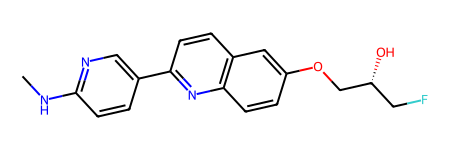

In [26]:
Chem.MolFromSmiles('CNC1=NC=C(C=C1)C2=NC3=C(C=C2)C=C(C=C3)OC[C@@H](CF)O') # 原始輸入：待預測的藥物

In [148]:
# load data
PREDICTION_DIR = './prediction/'
drugs_smiles = []
with open(PREDICTION_DIR + '/20200715.txt', 'r') as f:
    for smiles in f.readlines():
        drugs_smiles.append(smiles.split('\n')[0])

len(drugs_smiles)

184

In [149]:
test_smiles = tokenizer.texts_to_sequences(drugs_smiles)
test_smiles = np.squeeze(np.array(test_smiles))
test_smiles = sequence.pad_sequences(test_smiles, maxlen=SMILES_MAX_LEN, padding='post', value=tokenizer.word_index['<PAD>'])

In [143]:
vae.encoder.sampling.diversity = 3000

In [150]:
outputs = vae.predict(test_smiles)
pred_drug = np.argmax(outputs, axis=2)
# pred_drug

original_pred_drug = tokenizer.sequences_to_texts(pred_drug)
original_pred_drug = [x.replace(' ', '') for x in original_pred_drug]

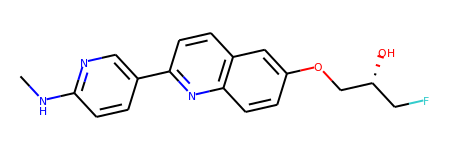

In [151]:
Chem.MolFromSmiles('CNC1=NC=C(C=C1)C2=NC3=C(C=C2)C=C(C=C3)OC[C@@H](CF)O') # 原始輸入

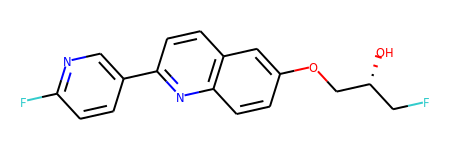

In [152]:
Chem.MolFromSmiles(original_pred_drug[2]) # 新生成全新的藥物